In [1]:
import numpy as np
import torch
from torch import nn
import random
import matplotlib.pyplot as plt
from scipy.optimize import dual_annealing
from utils import GradientBandit, GradientBanditNoStrat

In [2]:
class ConstantReward:
    def __init__(self,arms):
        reward = np.random.rand(arms)
        reward /= np.sum(reward)
        self.reward = reward

    def get_reward(self,context):
        return self.reward

In [3]:
class StrategicAgents:
    def __init__(self, dim, delta_radius, reward):
        self.delta_radius = delta_radius
        self.reward = reward
        self.dim = dim

    def generate_context(self, policy, priv):
        reward = self.reward.get_reward(priv)
        bounds = [(-self.delta_radius, self.delta_radius)] * (self.dim)
        def objective(delta):
            if np.linalg.norm(delta) > self.delta_radius:
                return np.inf
            #x_prime = np.append((priv+delta),[1])
            x_prime = priv+delta
            return -reward[np.argmax(policy@x_prime)]

        opt_delt = dual_annealing(objective, bounds)
        x_prime = priv + opt_delt.x

        return x_prime, reward[np.argmax(policy@x_prime)]
        #return x_prime, reward[np.argmax(policy@np.append(x_prime,[1]))]


In [4]:
class ImperfectStrategicAgents:
    def __init__(self, dim, delta_radius, reward, policy_noise):
        self.delta_radius = delta_radius
        self.reward = reward
        self.dim = dim
        self.policy_noise = policy_noise

    def generate_context(self, policy, priv):
        imp_policy = policy + self.policy_noise*(np.random.random(policy.shape)-0.5)
        reward = self.reward.get_reward(priv)
        bounds = [(-self.delta_radius, self.delta_radius)] * (self.dim)
        def objective(delta):
            if np.linalg.norm(delta) > self.delta_radius:
                return np.inf
            #x_prime = np.append((priv+delta),[1])
            x_prime = priv+delta
            return -reward[np.argmax(imp_policy@x_prime)]

        opt_delt = dual_annealing(objective, bounds)
        x_prime = priv + opt_delt.x

        return x_prime, reward[np.argmax(policy@x_prime)]
        #return x_prime, reward[np.argmax(policy@np.append(x_prime,[1]))]


In [5]:
class NonStrategicAgents:
    def __init__(self,  dim, delta_radius, reward):
        self.delta_radius = delta_radius
        self.reward = reward
        self.dim = dim

    def generate_context(self, policy, priv):
        reward = self.reward.get_reward(priv)

        return priv, reward[np.argmax(policy@priv)]
        #return priv, reward[np.argmax(policy@np.append(priv,[1]))]


In [6]:
# T = 100
# ARMS = 4
# CONTEXT_DIM = 5
# delta_radius = 0.5

# private_types = np.random.rand(T,CONTEXT_DIM)
# rewards = ConstantReward(ARMS)
# strat_agents = StrategicAgents(private_types,CONTEXT_DIM,delta_radius,rewards)
# nostrat_agents = NonStrategicAgents(private_types,CONTEXT_DIM,delta_radius,rewards)

In [7]:
# policy = np.random.rand(CONTEXT_DIM,ARMS) - 0.5
# print("policy: {} ".format(policy))
# print("reward: {} ".format(rewards.get_reward(0)))

Sanity check to make sure the strategic agents are performing better than non-strategic agents

In [8]:
# total_strat_reward = 0
# total_nostrat_reward = 0
# for i in range(T):
#     xp, strat_reward = strat_agents.generate_context(policy)
#     x, nostrat_reward = nostrat_agents.generate_context(policy)
#     total_strat_reward += strat_reward
#     total_nostrat_reward += nostrat_reward

# print("strategic reward: {}, non-strategic reward: {}".format(total_strat_reward,total_nostrat_reward))

In [9]:
class ModelReward:
    def __init__(self,arms,dim,noise=0.01):
        self.theta = np.random.rand(arms,dim)
        self.noise_scale = noise

    def get_reward(self,action,context):
        true_reward = action @ self.theta @ context
        return true_reward + (np.random.rand(1)-0.5) * 2*self.noise_scale

In [10]:
class StrategyAwareGradientModel:
    def __init__(self,T,est_reward,lr,dim,delta_radius,arms,reward_func):
        self.delta_radius = delta_radius
        self.t = 0
        self.T = T
        self.est_agent_reward = est_reward
        self.dim = dim
        self.model = GradientBandit(arms,dim,bias=False)
        self.reward_function = reward_func
        self.opt = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        self.criterion = torch.nn.L1Loss()

    def get_policy(self):
        return self.model.get_hyperplanes()

    def observe_reward(self, context):
        self.opt.zero_grad()
        context = torch.tensor(context).reshape(1,-1).float()
        est_agent_rew = torch.tensor(self.est_agent_reward.get_reward(context)).float()
        y_hat = self.model.forward(context,est_agent_rew)
        # print(y_hat)
        reward = self.reward_function.get_reward(y_hat,context)
        loss = self.criterion(1/reward,torch.zeros(1))
        loss.backward()
        self.opt.step()
        return reward

In [11]:
class StrategyUnawareGradientModel:
    def __init__(self,T,est_reward,lr,dim,delta_radius,arms,reward_func):
        self.delta_radius = delta_radius
        self.t = 0
        self.T = T
        self.est_agent_reward = est_reward
        self.dim = dim
        self.model = GradientBanditNoStrat(arms,dim,bias=False)
        self.reward_function = reward_func
        self.opt = torch.optim.SGD(self.model.parameters(), lr=lr, momentum=0.9)
        self.criterion = torch.nn.L1Loss()

    def get_policy(self):
        return self.model.get_hyperplanes()

    def different_(self, x_true, x_observed):
        est_agent_rew = self.est_agent_reward.get_reward(None)
        y_true = self.model.forward(torch.tensor(x_true).float(),est_agent_rew)
        y_obv = self.model.forward(torch.tensor(x_observed).float(),est_agent_rew)
        if torch.argmax(y_obv) != torch.argmax(y_true):
            better = est_agent_rew[torch.argmax(y_obv)] > est_agent_rew[torch.argmax(y_true)]
            return True, better
        else:
            return False, False

    def observe_reward(self, context):
        self.opt.zero_grad()
        context = torch.tensor(context).reshape(1,-1).float()
        est_agent_rew = torch.tensor(self.est_agent_reward.get_reward(context)).float()
        y_hat = self.model.forward(context,est_agent_rew)
        reward = self.reward_function.get_reward(y_hat,context)
        loss = self.criterion(1/reward,torch.zeros(1))
        loss.backward()
        self.opt.step()
        return reward

In [60]:
class StrategyUnawareModel:
    def __init__(self,T,est_reward,lr,dim,delta_radius,arms,reward_func):
        self.delta_radius = delta_radius
        self.t = 0
        self.T = T
        self.est_agent_reward = est_reward
        self.dim = dim
        self.policy= np.random.rand(arms,dim)
        self.reward_function = reward_func
        self.committed = False
        self.arms = arms
        rewards = [ [] for i in range(self.arms)]
        contexts = [ [] for i in range(self.arms)]
        for arm in range(arms):
            rewards[arm] = []
            contexts[arm] = []
        
        self.reward_data = rewards
        self.context_data = contexts

    def refresh_policy(self):
        self.policy= np.random.rand(self.arms,self.dim)        

    def get_policy(self):
        return self.policy

    def committ(self):
        theta = np.zeros((self.arms,self.dim))
        for arm in range(self.arms):
            xs = np.asarray(self.context_data[arm])
            ys = np.asarray(self.reward_data[arm])
            
            est_theta = np.linalg.lstsq(xs,ys,rcond=None)[0]
            theta[arm,:] = est_theta.flatten()

        self.policy = theta

    def different_(self, x_true, x_observed):
        est_agent_rew = self.est_agent_reward.get_reward(None)
        y_true = self.policy@x_true
        y_obv = self.policy@x_observed
        if np.argmax(y_obv) != np.argmax(y_true):
            better = est_agent_rew[np.argmax(y_obv)] > est_agent_rew[np.argmax(y_true)]
            return True, better
        else:
            return False, False

    def get_action(self,context):
        expected_rewards = self.policy@context
        action = np.argmax(expected_rewards)
        return action

    def observe_reward(self, action, context):
        est_agent_rew = self.est_agent_reward.get_reward(context)

        action_vector = np.zeros(self.arms)
        action_vector[action] += 1
        reward = self.reward_function.get_reward(action_vector,context)

        self.reward_data[action] += [reward]
        self.context_data[action] += [context]

        return reward, action

In [65]:
T = 1200
ARMS = 4
CONTEXT_DIM = 5
DELTA = 0.25
lr = 0.1
model_reward_noise = 0.05
imperfect_agent_policy_noise = 0.05

private_types = np.random.rand(T,CONTEXT_DIM)
agent_rewards = ConstantReward(ARMS)
model_reward_func = ModelReward(ARMS,CONTEXT_DIM,model_reward_noise)
strat_agents = StrategicAgents(CONTEXT_DIM,DELTA,agent_rewards)
imperfect_agents = ImperfectStrategicAgents(CONTEXT_DIM,DELTA,agent_rewards,imperfect_agent_policy_noise)
nostrat_agents = NonStrategicAgents(CONTEXT_DIM,DELTA,agent_rewards)
model = StrategyUnawareModel(T,agent_rewards,lr,CONTEXT_DIM,DELTA,ARMS,model_reward_func)


strat_agent_errors = 0
impf_agent_error = 0
regret = [0]
for i in range(T):
    if i % 3 == 0:
        x,agent_reward = nostrat_agents.generate_context(model.get_policy(), private_types[i])
    elif i % 3 == 1:
        x, agent_reward = imperfect_agents.generate_context(model.get_policy(), private_types[i])
    else:
        x,agent_reward = strat_agents.generate_context(model.get_policy(), private_types[i])
    
    action = model.get_action(x)
    reward = model.observe_reward(action,x)
    different, better = model.different_(x,private_types[i])
    true_act = np.argmax(model_reward_func.theta @ private_types[i])
    regret.append(regret[-1] + (true_act != action))
    if i < T//2:
        model.refresh_policy()
    elif i == T//2:
        model.committ()

    if different:
        if i % 3 == 1:
            impf_agent_error += 1
        else:
            strat_agent_errors += 1

print("strat errors: {} | impf errors: {}".format(strat_agent_errors,impf_agent_error))
    

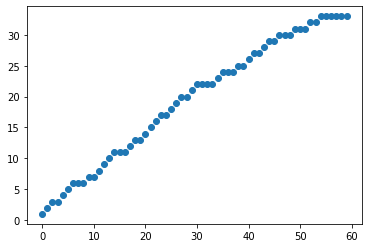

In [64]:
x = range(T)
plt.scatter(x, regret[1:])
plt.show()

In [59]:
print(model.get_policy() - model_reward_func.theta)

[[-0.00764596 -0.01625134 -0.00687294 -0.01193293  0.05755617]
 [-0.02455891 -0.00220384 -0.00910528 -0.00386984  0.00795818]
 [ 0.04274479 -0.10335167  0.04604875  0.03231198  0.04248598]
 [ 0.09833547 -0.06452297 -0.09266993  0.06593723  0.00417664]]


20
20
strat: 0.3505486060025757 | impf: 0.33543223262133254 | no strat: 0.3435960223000631


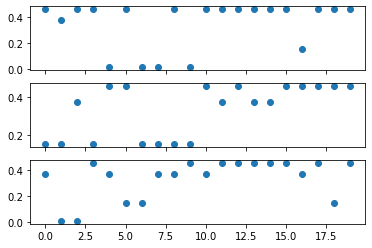

In [56]:
# x = range(T//3)
# fig, axs = plt.subplots(3, sharex=True, sharey=False)
# print(len(x))
# print(len([x.item() for x in model_rewards_strat]))
# axs[0].scatter(x, [x.item() for x in model_rewards_strat])
# axs[1].scatter(x, [x.item() for x in model_rewards_imp])
# axs[2].scatter(x, [x.item() for x in model_rewards_ns])
# print("strat: {} | impf: {} | no strat: {}".format(sum([3*x.item() for x in model_rewards_strat])/T, sum([3*x.item() for x in model_rewards_imp])/T,sum([3*x.item() for x in model_rewards_ns])/T,))